In [1]:
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train.head()

filename  x1   y1   x2   y2   x3   y3   x4   y4   x5  ...  x10  y10  x11  \
0  05317.jpg  25   55   63   39  145   36  171   45   39  ...  159   65  113   
1  04767.jpg  17   32   39   27   56   22   81   16   20  ...   86   28   56   
2  05241.jpg  33   44   70   44  119   41  142   41   33  ...  144   56   94   
3  03849.jpg  96  157  222  143  389  129  517  125  153  ...  467  188  328   
4  00952.jpg  13   19   30   16   51   17   66   16   18  ...   59   23   39   

   y11  x12  y12  x13  y13  x14  y14  
0  103   79  148  113  148  143  141  
1   66   45   80   59   80   74   76  
2  101   74  135   89  135  112  133  
3  339  241  451  335  453  419  441  
4   43   31   56   41   56   49   55  

[5 rows x 29 columns]

## Посмотрим на имеющиеся изображения

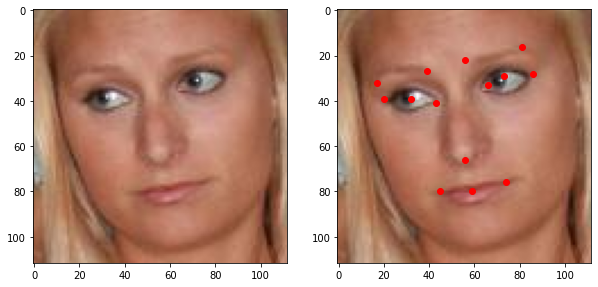

In [4]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/train/04767.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
keypoints = train.loc[train['filename'] == '04767.jpg'].values[0][1:]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,8)
ax1.imshow(img)
ax2.imshow(img)
ax2.scatter(x=keypoints[::2], y=keypoints[1::2], color='r');

In [5]:
train.isna().any().any() # пропущенных значений в ключевых точках нет

False

### Загрузим изображения из папки train

In [6]:
def get_raw_images_df(dirname):
    raw_img = []
    for filename in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        raw_img.append([filename, img, img.shape[0], img.shape[1]])
    raw_img = pd.DataFrame(raw_img, columns=['filename','raw_img','height', 'width'])
    return raw_img

In [7]:
raw_img = get_raw_images_df('/content/drive/MyDrive/Colab Notebooks/train')

In [8]:
train_img = train.merge(raw_img, on='filename') # соединим изображения с их ключевыми точками в датафрейме

## Data Augmentation

Сначала хотела использовать `ImageDataGenerator`, но потом прочитала, что он deprecated и вместо него следует использовать `keras preprocessing_layers`, и там есть разные слои для расширения данных.

Все эти варианты не очень подходят, так как с некоторые изменения изображения влекут и изменение координат наших ключевых точек (сдвиги, вращения и т.д.), поэтому эти трансформации придется прописать самостотельно.

Также я заметила, что не все изображения квадратные, поэтому небольшое количество неквадратных (278) можно обрезать до квадрата.

In [9]:
train_img[train_img['height'] != train_img['width']].shape[0]

278

In [10]:
keypoint_cols = [letter + str(i+1) for i in range(14) for letter in ['x', 'y']] 
x_cols = ['x' + str(i+1) for i in range(14)]
y_cols = ['y' + str(i+1) for i in range(14)]

In [11]:
def square_img(data, training=True):
    def central_crop(img, shape):
        width = shape[1]
        height = shape[0]
        if width > height:
            img = img[:, width//2-height//2 : width//2+height//2]
        elif height > width:
            img = img[height//2-width//2 : height//2+width//2,:]
        return img
    
    df = data.copy()
    if training:
      rows_to_drop = None
      wider = df['width'] > df['height']
      higher = df['height'] > df['width']

      for x, y in zip(x_cols, y_cols): 
          df.loc[wider,x] -= df[wider]['width']/2 - df[wider]['height']/2
          df.loc[higher,y] -= df[higher]['height']/2 - df[higher]['width']/2
          if (df[x] < 0).any():
              if rows_to_drop is None:
                  rows_to_drop = df[df[x] < 0].index
              else:
                  rows_to_drop = rows_to_drop.union(df[df[x] < 0].index)
          if (df[y] < 0).any():
              if rows_to_drop is None:
                  rows_to_drop = df[df[y] < 0].index
              else:
                  rows_to_drop = rows_to_drop.union(df[df[y] < 0].index)
                  
      if rows_to_drop is not None:
          df.drop(rows_to_drop, inplace=True)

    df['raw_img'] = df['raw_img'].apply(lambda x: central_crop(x, x.shape[:-1]))
    df['size'] = np.min(df[['height','width']], axis=1)
    return df

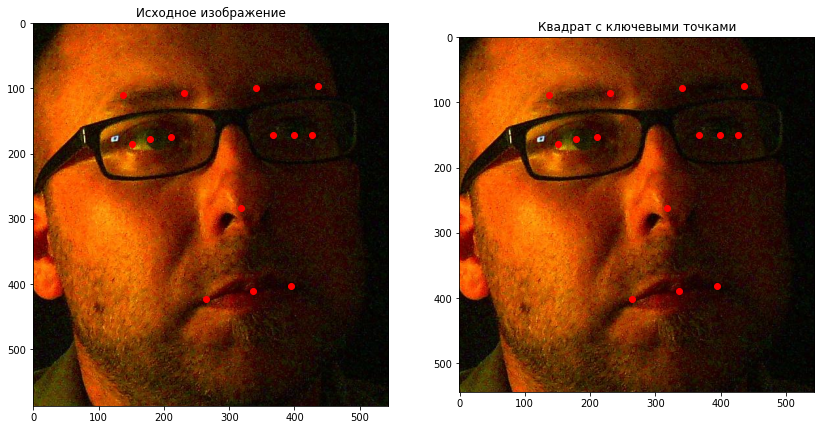

In [12]:
train_img.dropna(axis=0, inplace=True)
train_cropped = square_img(train_img) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14,8)
ind = train_img[train_img['width'] != train_img['height']].index[0]
ax1.imshow(train_img.loc[ind]['raw_img'])
ax1.scatter(x=train_img.loc[ind][x_cols], y=train_img.loc[ind][y_cols], color='r')
ax2.imshow(train_cropped.loc[ind]['raw_img'])
ax2.scatter(x=train_cropped.loc[ind][x_cols], y=train_cropped.loc[ind][y_cols], color='r')

ax1.set_title('Исходное изображение')
ax2.set_title('Квадрат с ключевыми точками');

Теперь все изображения квадратные, и их можно привести к одному размеру и пересчитать координаты точек.

Заодно можно значения пикселей перевести в диапазон от 0 до 1, разделив их на 255.

In [13]:
def resize_and_normalize(df, new_size, training=True):
    def resize_img(img, new_size):
      img = cv2.resize(img, (new_size, new_size)) / 255.0
      if img.ndim == 2:
        img = np.dstack((img,img,img))
      return img
    
    df['raw_img'] = df['raw_img'].apply(lambda x: resize_img(x, new_size))
    if training:
        scale = new_size/df['size']
        for x, y in zip(x_cols, y_cols):
            df[x] -= df['size']/2   
            df[x] *= scale
            df[x] += new_size/2
            df[x] = np.round(df[x],2)
            
            df[y] = df['size']/2 - df[y]
            df[y] *= scale
            df[y] = new_size/2 - df[y] 
            df[y] = np.round(df[y],2)
        df['size'] = new_size   

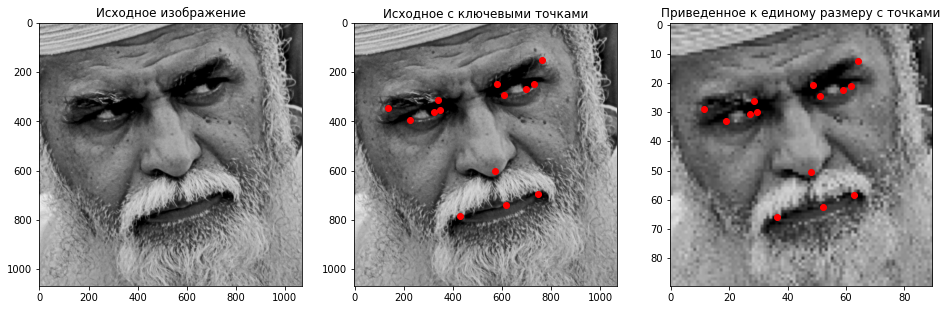

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16,9)
ax1.imshow(train_cropped.iloc[10]['raw_img'])
ax2.imshow(train_cropped.iloc[10]['raw_img'])
ax2.scatter(x=train_cropped.iloc[10][x_cols], y=train_cropped.iloc[10][y_cols], color='r')

NEW_SIZE = 90 # для начала выберем размеры 90х90
# потом можно будет скорректировать размеры в зависимости от того, как будет обучаться модель.

resize_and_normalize(train_cropped, NEW_SIZE)

ax3.imshow(train_cropped.iloc[10]['raw_img'])
ax3.scatter(x=train_cropped.iloc[10][x_cols], y=train_cropped.iloc[10][y_cols], color='r')

ax1.set_title('Исходное изображение')
ax2.set_title('Исходное с ключевыми точками')
ax3.set_title('Приведенное к единому размеру с точками');

Теперь все изображения в тренировочном датасете приведены к единому размеру. Добавим некоторые функции, которые будут изменять имеющиеся данные и тем самым расширять датасет.

## Отражение

In [15]:
def flip(data, vertical, fraction=0.3):
    
    df = data.sample(frac=fraction, replace=False)
    
    flip_type = 0 if vertical else 1
    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.flip(x, flip_type))
    if vertical:
        for y in y_cols:
            df[y] = df['size'] - df[y]  
    else:
        for x in x_cols:
            df[x] = df['size'] - df[x]

    return df

## Поворот на любой угол

In [16]:
def rotate_any(data, fraction, angle):

    def cv_rotation(img, angle):
        rot_mat = cv2.getRotationMatrix2D((NEW_SIZE/2, NEW_SIZE/2), angle, 1.0)
        rotated_img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        return rotated_img

    df = data.sample(frac=fraction, replace=False)
    angle_rad = np.pi*angle/180
    
    df['raw_img'] = df['raw_img'].apply(lambda x: cv_rotation(x, angle))
    
    for x, y in zip(x_cols, y_cols):
        df[x] -= df['size']/2
        df[y] = df['size']/2 - df[y]
        
        df[x] = df[x]*np.cos(angle_rad) - df[y]*np.sin(angle_rad)
        df[y] = df[x]*np.sin(angle_rad) + df[y]*np.cos(angle_rad)
        
        df[x] += df['size']/2
        df[y] = df['size']/2 - df[y] 

    return df

Для углов, кратных 90, отдельная функция, потому что для них можно пересчитать координаты точек легче и без тригонометрии.

In [17]:
def rotate_90(data, angle, fraction):
    
    df = data.sample(frac=fraction, replace=False)

    if angle == 90 or angle == -270:
        rot = cv2.ROTATE_90_CLOCKWISE
        for x, y in zip(x_cols, y_cols):
            tmp = df[y].copy()
            df[y] = df[x]
            df[x] = df['size'] - tmp
    elif angle == 180:
        rot = cv2.ROTATE_180
        for x, y in zip(x_cols, y_cols):
            df[x] = df['size'] - df[x]
            df[y] = df['size'] - df[y]
    elif angle == 270 or angle == -90: 
        rot = cv2.ROTATE_90_COUNTERCLOCKWISE
        for x, y in zip(x_cols, y_cols):
            tmp = df[x].copy()
            df[x] = df[y]
            df[y] = df['size'] - tmp
        
    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.rotate(x, rot)) 

    return df

## Сдвиг

Если сильно сдвигать изображение, на 20-30 пикселей при размере около 100х100, то высока вероятность, что какая-то из ключевых точек "выйдет из кадра". 

В функции ниже проверяется наличие таких изображений и в итоговую выборку они не попадают.

In [18]:
def shift(data, hor_shift, ver_shift, fraction):
    df = data.sample(frac=fraction, replace=False)
    M = np.float32([[1,0,hor_shift],[0,1,ver_shift]])
    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.warpAffine(x,M,x.shape[1::-1]))
    rows_to_drop = None
    for x, y in zip(x_cols, y_cols):
        df[x] += hor_shift
        df[y] += ver_shift
        if (df[x] < 0).any() or (df[x] > df['size']).any():
            if rows_to_drop is None:
                rows_to_drop = df[df[x] < 0].index
            else:
                rows_to_drop = rows_to_drop.union(df[df[x] < 0].index)
        if (df[y] < 0).any() or (df[y] > df['size']).any():
            if rows_to_drop is None:
                rows_to_drop = df[df[y] < 0].index
            else:
                rows_to_drop = rows_to_drop.union(df[df[y] < 0].index)
                
    if rows_to_drop is not None:
        df.drop(rows_to_drop, inplace=True) 
    
    return df

## Зум (отдаление/приближение)

С приближением есть такая же проблема, что точки могут вылеть за рамки, поэтому не рекомендуется сильно увеличивать изображения, но в любом случае невалидные сэмплы в итоговый датасет не попадут.

In [19]:
def zoom(data, zoom, fraction):
    def cv_zoom(img, zoom):
        rot_mat = cv2.getRotationMatrix2D((NEW_SIZE/2,NEW_SIZE/2), 0, zoom)
        result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        return result
    
    df = data.sample(frac=fraction)
    df['raw_img'] = df['raw_img'].apply(lambda x: cv_zoom(x, zoom))
    rows_to_drop = None
    for x, y in zip(x_cols, y_cols):
        df[x] -= df['size']/2    
        df[x] *= zoom
        df[x] += df['size']/2
        df[x] = np.round(df[x],2)
        
        df[y] = df['size']/2 - df[y]
        df[y] *= zoom
        df[y] = df['size']/2 - df[y] 
        df[y] = np.round(df[y],2)
        if (df[x] < 0).any():
            if rows_to_drop is None:
                rows_to_drop = df[df[x] < 0].index
            else:
                rows_to_drop = rows_to_drop.union(df[df[x] < 0].index)
        if (df[y] < 0).any():
            if rows_to_drop is None:
                rows_to_drop = df[df[y] < 0].index
            else:
                rows_to_drop = rows_to_drop.union(df[df[y] < 0].index)
    if rows_to_drop is not None:
        df.drop(rows_to_drop, inplace=True) 
    
    return df

## Преобразования, не меняющие координаты точек


In [20]:
def contrast_brightness(data, fraction, c_factor=1, b_factor=0):
    
    df = data.sample(frac=fraction, replace=False)

    df['raw_img'] = df['raw_img'].apply(lambda x: cv2.convertScaleAbs(x*255.0, alpha=c_factor, beta=b_factor)/255.0)
    
    return df

# Расширение данных и соединение в один датасет

In [21]:
# для экономии памяти 
del raw_img
del train_img

In [22]:
flipped_v = flip(train_cropped,  vertical=True, fraction=0.2)
flipped_h = flip(train_cropped,  vertical=False, fraction=0)

rotated_20 = rotate_any(train_cropped, fraction=0.1, angle=-20)
rotated_m15 = rotate_any(train_cropped, fraction=0.1, angle=-15)
rotated_90 = rotate_90(train_cropped, fraction=0.25, angle=90)
rotated_90_ = rotate_90(train_cropped, fraction=0.25, angle=-90)
rotated_180 = rotate_90(train_cropped, fraction=0.2, angle=180)

shifted_10 = shift(train_cropped, 10, -10, fraction=0.1)
shifted_20 = shift(train_cropped, -20, 20, fraction=0.1)

zoomed_12 = zoom(train_cropped, zoom=1.2, fraction=0.1)
zoomed_08 = zoom(train_cropped, zoom=0.8, fraction=0.1)

c15_b50 = contrast_brightness(train_cropped, fraction=0.05, c_factor=1.5, b_factor=50)
c08_b40 = contrast_brightness(train_cropped, fraction=0.05, c_factor=0.8, b_factor=-40)

augmented_data = pd.concat([flipped_v, flipped_h,
                               rotated_20, rotated_m15,
                               rotated_90, rotated_90_,
                               rotated_180, shifted_10,
                               shifted_20, zoomed_12, zoomed_08,
                               c15_b50, c08_b40], ignore_index=True, copy=False)
augmented_data.shape

(7564, 33)

Text(0.5, 0.98, 'Модификации данных')

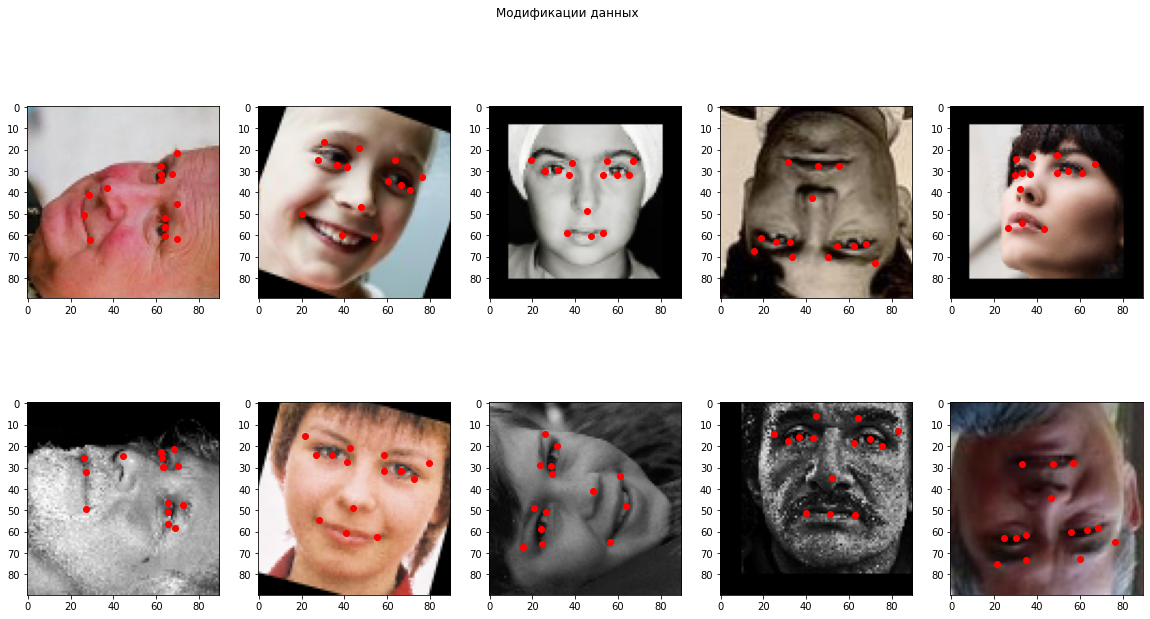

In [23]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(20,10)
for ax in axes.flatten():
    ind = rng.integers(augmented_data.shape[0])
    ax.imshow(augmented_data.iloc[ind]['raw_img'])
    ax.scatter(x=augmented_data.iloc[ind][x_cols], 
               y=augmented_data.iloc[ind][y_cols], color='r')
fig.suptitle('Модификации данных')

In [24]:
del flipped_h
del rotated_20
del shifted_10
del shifted_20
del zoomed_12
del zoomed_08
del c15_b50
del c08_b40

In [25]:
train_full = pd.concat([train_cropped, augmented_data], ignore_index=True, copy=False)
train_full.shape

del train_cropped
del augmented_data

In [26]:
from sklearn.model_selection import train_test_split

INPUT_SIZE = NEW_SIZE

X_train, X_test, y_train, y_test = train_test_split(np.stack(train_full['raw_img']), train_full[keypoint_cols].values, test_size=0.3, shuffle=True, random_state=1001)

In [27]:
del train_full

In [28]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.regularizers

In [29]:
input_shape = (INPUT_SIZE, INPUT_SIZE, 3)

model = Sequential()

model.add(InputLayer(input_shape=input_shape))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="linear", padding="same"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="linear", input_shape=input_shape, padding="same"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="linear", padding="same"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="linear", padding="same"))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="linear", padding="same"))#
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="linear", padding="same", kernel_regularizer = keras.regularizers.l2( l=0.12)))#
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=512, activation="linear"))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=28))

In [30]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
es_val = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.7,
                              patience = 6,
                              min_lr = 1e-7,
                              mode = 'min',
                              verbose = 1)


model.compile(optimizer='adam',loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])

In [31]:
#history = model.fit(X_train,y_train,batch_size=128,epochs=200,validation_split=0.3, callbacks=[es, reduce_lr, es_val], shuffle=True)


In [33]:
#можно загрузить уже обученную модель
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final_model.h5')

In [34]:
y_pred = model.predict(X_test)
print((y_pred < 0).sum())
print((y_pred > NEW_SIZE).sum())
#посмотрим, сколько предсказанных координат вышли за допустимые пределы

118/118 [==============================] - 12s 30ms/step
1
5


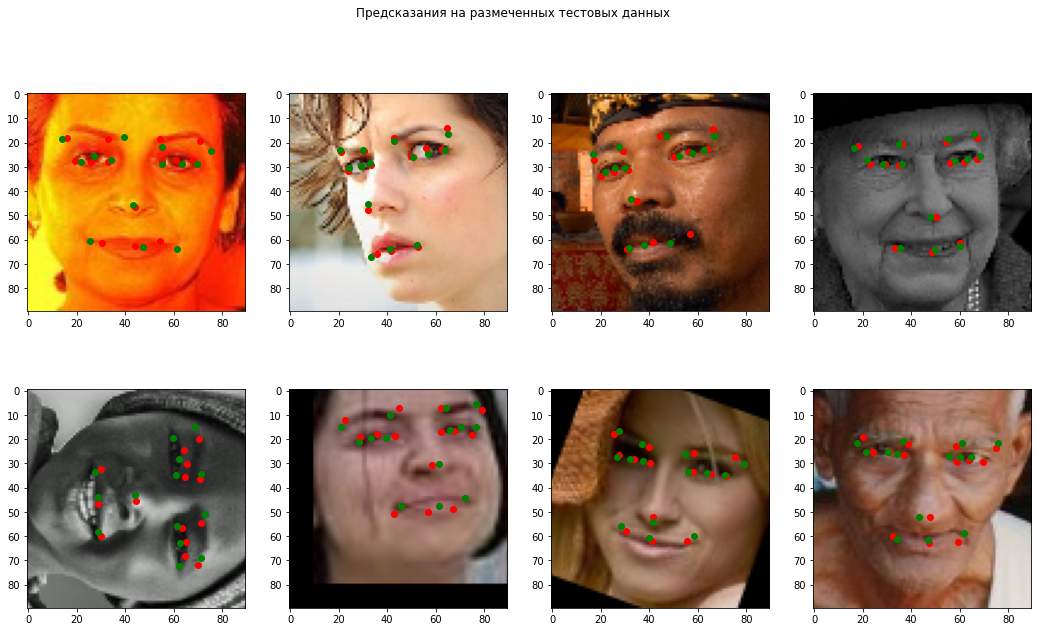

In [37]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(18,10)
for ax in axes.flatten():
    ind = rng.integers(X_test.shape[0])
    ax.imshow(X_test[ind])
    ax.scatter(x=y_pred[ind][::2],
               y=y_pred[ind][1::2], color='r')
    ax.scatter(x=y_test[ind][::2],
               y=y_test[ind][1::2], color='g')

fig.suptitle('Предсказания на размеченных тестовых данных')
plt.show()

32/32 [==============================] - 1s 28ms/step


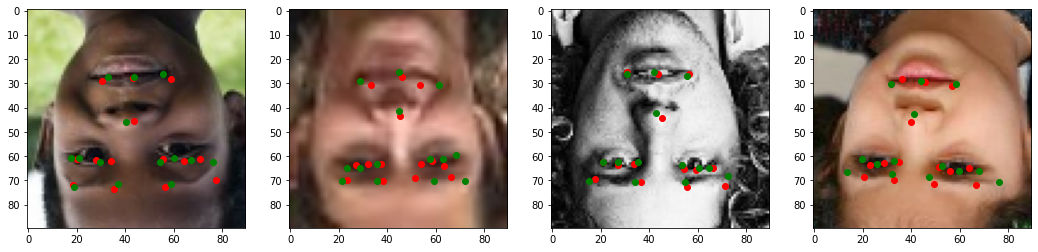

In [40]:
y_pred_aug = model.predict(np.stack(rotated_180['raw_img']))

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18,10)
for ax in axes.flatten():
    ind = rng.integers(rotated_180.shape[0])
    ax.imshow(rotated_180['raw_img'].iloc[ind])
    ax.scatter(x=y_pred_aug[ind][::2],
               y=y_pred_aug[ind][1::2], color='r')
    ax.scatter(x=rotated_180.iloc[ind][keypoint_cols[::2]],
               y=rotated_180.iloc[ind][keypoint_cols[1::2]], color='g')
plt.show()

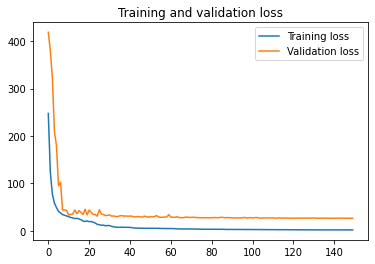

In [68]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error, r2_score

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

28.964336403667662
0.8669764633254392


#Загружаем неразмеченные тестовые данные


In [42]:
raw_img_test = get_raw_images_df('/content/drive/MyDrive/Colab Notebooks/test') 
print(raw_img_test.isna().any().any()) 

False


In [43]:
test_cropped = square_img(raw_img_test, training=False)

In [44]:
resize_and_normalize(test_cropped, NEW_SIZE, training=False)

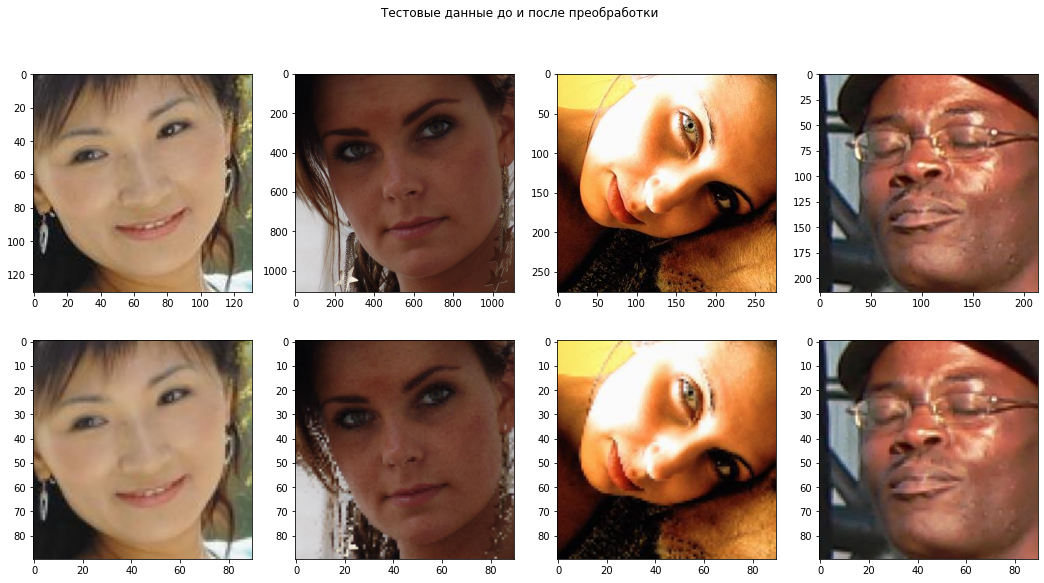

In [45]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(18,9)
for i in range(4):
    ind = rng.integers(raw_img_test.shape[0])
    axes[0,i].imshow(raw_img_test.iloc[ind]['raw_img'])
    axes[1,i].imshow(test_cropped.iloc[ind]['raw_img'])
fig.suptitle('Тестовые данные до и после преобработки');

In [46]:
y_pred_unmarked = model.predict(np.stack(test_cropped['raw_img']))

32/32 [==============================] - 1s 27ms/step


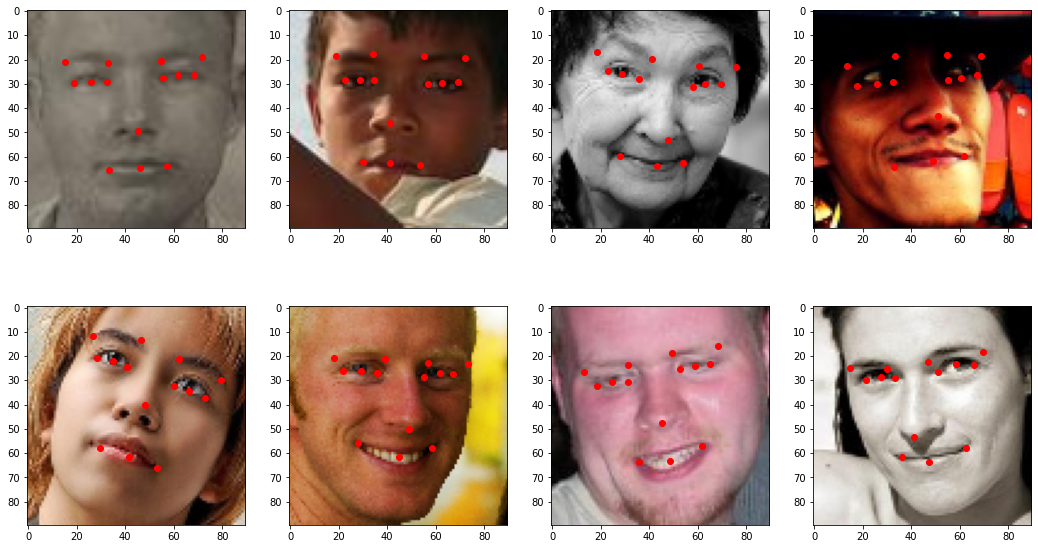

Text(0.5, 0.98, 'Предсказания на НЕразмеченных тестовых данных')

In [47]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(18,10)
for ax in axes.flatten():
    ind = rng.integers(test_cropped['raw_img'].shape[0])
    ax.imshow(test_cropped.iloc[ind]['raw_img'])
    ax.scatter(x=y_pred_unmarked[ind][::2],
               y=y_pred_unmarked[ind][1::2], color='r')
plt.show()
fig.suptitle('Предсказания на НЕразмеченных тестовых данных')

In [48]:
def reverse_resizing(y_pred, test_data, old_size):

    df = pd.DataFrame(y_pred.copy(), columns=[keypoint_cols])

    scale = test_data['size']/old_size
    
    for x, y in zip(x_cols, y_cols):#zip(x_cols, y_cols)

        df[x] -= old_size/2  

        df[x] = scale*np.asarray(df[x]).ravel()
        df[x] += np.asarray(test_data['size']).reshape(-1,1)/2
        
        df[x] = np.round(df[x],2)
        df[y] = old_size/2 - df[y]
        
        df[y] = scale*np.asarray(df[y]).ravel()
        df[y] = np.asarray(test_data['size']).reshape(-1,1)/2 - df[y] 
        df[y] = np.round(df[y],2)
        
    return df

In [49]:
test = reverse_resizing(y_pred_unmarked, test_cropped, INPUT_SIZE)

In [50]:
def reverse_cropping(test, raw_img):
    
    df = test.copy()
    wider_mask = raw_img['width'] > raw_img['height']
    higher_mask = raw_img['height'] > raw_img['width']
    w_h_difference = raw_img[wider_mask]['width']/2 - raw_img[wider_mask]['height']/2
    h_w_difference = raw_img[higher_mask]['height']/2 - raw_img[higher_mask]['width']/2
    for x, y in zip(x_cols, y_cols):
        df.loc[wider_mask,x] = df.loc[wider_mask,x]  + w_h_difference.to_numpy().reshape(-1,1)
        df.loc[higher_mask,y] = df.loc[higher_mask,y] + h_w_difference.to_numpy().reshape(-1,1)
 
    return df

In [51]:
test_full = reverse_cropping(test, raw_img_test)

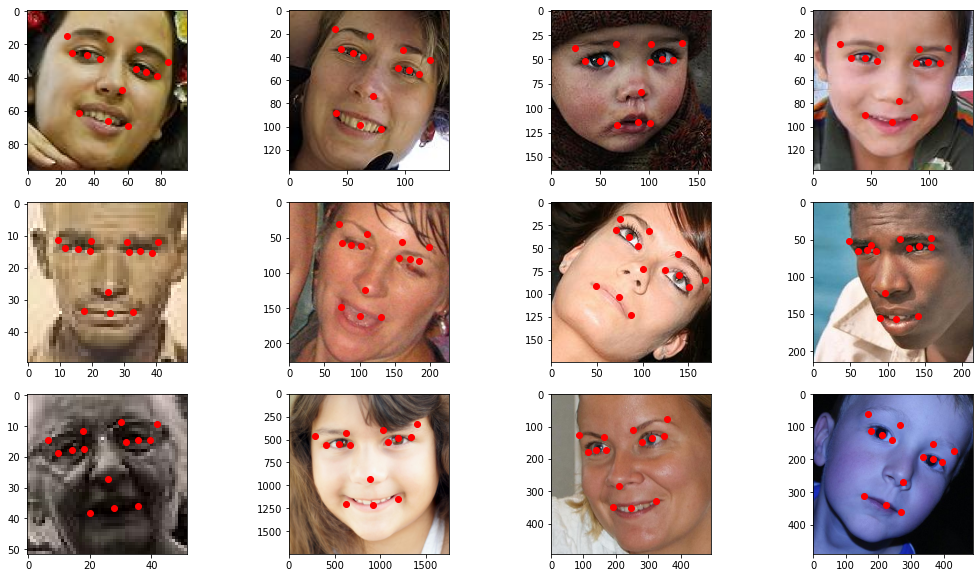

In [52]:
fig, axes = plt.subplots(3, 4)
fig.set_size_inches(18,10)

for ax in axes.flatten():
    ind = rng.integers(raw_img_test['raw_img'].shape[0])
    ax.imshow(raw_img_test.iloc[ind]['raw_img'])
    ax.scatter(x=test_full.iloc[ind][::2],
               y=test_full.iloc[ind][1::2], color='r')
    
plt.show()

In [ ]:
test_full.head()

x1      y1      x2      y2      x3      y3      x4      y4      x5  \
0  155.71  170.65  297.16  142.53  453.55  143.57  558.48  153.76  187.46   
1   18.53   18.80   36.43   17.72   52.82   17.77   69.57   19.27   22.00   
2   43.35   51.21   97.08   54.64  141.84   55.43  189.64   53.53   55.73   
3   15.95   19.71   34.24   19.75   53.31   19.78   70.45   19.18   21.41   
4   43.00   52.58   77.16   54.07  114.84   51.09  169.76   48.28   56.64   

       y5  ...     x10     y10     x11     y11     x12     y12     x13  \
0  228.81  ...  550.71  226.89  405.39  355.87  263.34  510.84  386.13   
1   25.90  ...   66.54   27.26   44.81   43.55   31.92   59.40   46.31   
2   72.66  ...  173.44   74.06  118.19  134.13   82.50  164.98  116.36   
3   27.21  ...   69.63   27.28   46.92   49.61   31.51   59.95   48.06   
4   72.98  ...  161.10   66.73   88.62  126.74   85.63  162.88  107.68   

      y13     x14     y14  
0  506.91  482.93  508.93  
1   59.98   58.69   59.13  
2  171.06  143.90  166.14  
3   63.36   65.43   59.08  
4  165.85  143.16  161.92  

[5 rows x 28 columns]

In [53]:
test_generated = raw_img_test.join(test_full, how='left')
test_generated.drop(columns=['raw_img','height','width'], axis=1, inplace=True)

In [54]:
test_generated.to_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')